<a href="https://colab.research.google.com/github/kochol/tf_tests/blob/master/test01_export_model_to_tfjs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test 01

This is my first try with Tensorflow to predicte the Bitcoin price.

In [0]:
!pip install tensorflowjs

import tensorflow as tf
from tensorflow.keras import layers

# enable tf eager execution to support iterating
#tf.enable_eager_execution()

#print(tf.VERSION)
#print(tf.keras.__version__)

## Create the model

In [0]:
inputs = tf.keras.Input(shape=(7))  # Returns a placeholder tensor

# A layer instance is callable on a tensor, and returns a tensor.
x = layers.Dense(64, activation='relu')(inputs)
predictions = layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=predictions)

# I want to calc on float numbers so I use mse and mae for loss and metrics
# Also I have to find out which optimizer is good for me.
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
              loss='mse',
              metrics=['mae', 'mse'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


## Load data from csv file

In [0]:
import pandas as pd
import numpy as np

# Download mydata.csv from github
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/kochol/tf_tests/master/mydata.csv

# load all data
mydata = pd.read_csv("mydata.csv")

print(mydata.columns)
print(mydata.dtypes)
print(mydata.shape)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  154k  100  154k    0     0   933k      0 --:--:-- --:--:-- --:--:--  933k
Index(['start', 'open', 'high', 'low', 'close', 'vwp', 'volume', 'trades'], dtype='object')
start       int64
open      float64
high      float64
low       float64
close     float64
vwp       float64
volume    float64
trades      int64
dtype: object
(1884, 8)


### Prepare the data for training

In [0]:
train = pd.DataFrame(
    {
        'open': mydata[0:-101].open.astype('int32'),
        'high': mydata[0:-101].high.astype('int32'),
        'low': mydata[0:-101].low.astype('int32'),
        'close': mydata[0:-101].close.astype('int32'),
        'vwp': mydata[0:-101].vwp.astype('int32'),
        'volume': mydata[0:-101].volume.astype('int32'),
        'trades': mydata[0:-101].trades.astype('int32')
    })
print(train.columns)
print(train.dtypes)
print(train.shape)

test = pd.DataFrame({'price': mydata[1:-100].close.astype('int32')})
print(test.columns)
print(test.dtypes)
print(test.shape)

val_in = pd.DataFrame(
    {
        'open': mydata[-100:].open.astype('int32'),
        'high': mydata[-100:].high.astype('int32'),
        'low': mydata[-100:].low.astype('int32'),
        'close': mydata[-100:].close.astype('int32'),
        'vwp': mydata[-100:].vwp.astype('int32'),
        'volume': mydata[-100:].volume.astype('int32'),
        'trades': mydata[-100:].trades.astype('int32')
    })
print(val_in.shape)

val_test = pd.DataFrame({'price': mydata[-100:].close.astype('int32')})
print(val_test.shape)

Index(['open', 'high', 'low', 'close', 'vwp', 'volume', 'trades'], dtype='object')
open      int32
high      int32
low       int32
close     int32
vwp       int32
volume    int32
trades    int32
dtype: object
(1783, 7)
Index(['price'], dtype='object')
price    int32
dtype: object
(1783, 1)
(100, 7)
(100, 1)


## Train the model

In [0]:
train_np = train.to_numpy()
test_np = test.to_numpy()
model.fit(train_np, test_np, epochs=1100, batch_size=32)#, validation_split = 0.2)

Epoch 1/1100
1783/1783 [==============================] - 0s 104us/sample - loss: 8164664.0360 - mae: 2224.2207 - mse: 8164665.0000
Epoch 2/1100
1783/1783 [==============================] - 0s 37us/sample - loss: 108989.1202 - mae: 123.4019 - mse: 108989.1016
Epoch 3/1100
1783/1783 [==============================] - 0s 38us/sample - loss: 18200.7786 - mae: 86.7605 - mse: 18200.7773
Epoch 4/1100
1783/1783 [==============================] - 0s 37us/sample - loss: 10651.0376 - mae: 81.3864 - mse: 10651.0371
Epoch 5/1100
1783/1783 [==============================] - 0s 37us/sample - loss: 10354.8955 - mae: 75.3313 - mse: 10354.8936
Epoch 6/1100
1783/1783 [==============================] - 0s 38us/sample - loss: 8297.5665 - mae: 71.0096 - mse: 8297.5654
Epoch 7/1100
1783/1783 [==============================] - 0s 37us/sample - loss: 9458.4770 - mae: 69.4019 - mse: 9458.4775
Epoch 8/1100
1783/1783 [==============================] - 0s 38us/sample - loss: 10161.7899 - mae: 80.5341 - mse: 10161

## Now test the model

Test the network with the 100 last prices.
We didn't use this prices to train the model.

Text(0.5, 1.0, 'BTC price prediction')

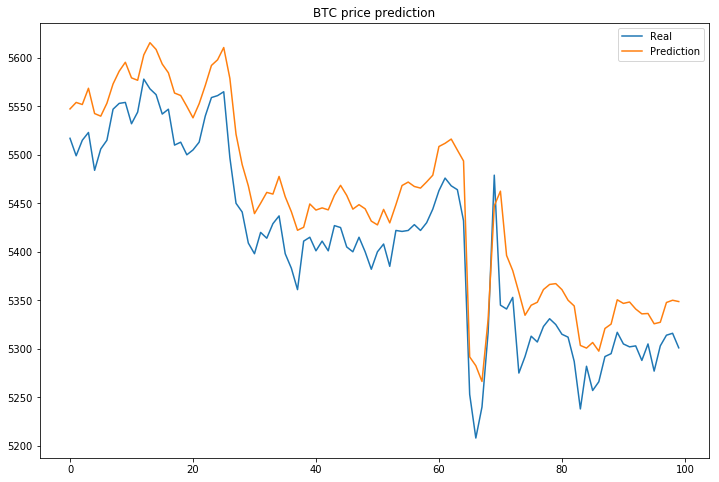

In [0]:
example_batch = val_in.to_numpy()
example_result = model.predict(example_batch)

import matplotlib.pyplot as plt
ex_b = pd.DataFrame({'price': val_test.price})
ex_r = pd.DataFrame(example_result)

plt.figure(figsize = (12,8))
plt.plot(ex_r.index, ex_b,label = 'Real')
plt.plot(ex_r.index, ex_r, label = 'Prediction')
plt.legend(loc = 'best')
plt.title('BTC price prediction')

## Save the model to tensorflowjs

In [0]:
model.save('mymodel.h5')
!mkdir mymodel_js
!tensorflowjs_converter --input_format keras \
                       mymodel.h5 \
                       mymodel_js

mkdir: cannot create directory ‘mymodel_js’: File exists
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
